This is what I did to prepare the data for the tutorial. The other notebook utilizes some smaller intermediate datasets because of what I can share via Github and what is possible during a tutorial with unpredictable internect connectivity.

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import glob
from pathlib import Path
from tqdm import tqdm
from skimage.restoration import denoise_tv_bregman
import sys
sys.path.append('utils/')
from nd_tools import scale_img
from rio_tools import get_cropped_profile, rasterize_shapes_to_array
from rasterio.transform import array_bounds
from shapely.geometry import box
import geopandas as gpd

# FTP

To be completed...

# Cropping

In [2]:
data = sorted(list(Path('data/jaxa_mosaics').glob('*.tif')))
data

[PosixPath('data/jaxa_mosaics/N05E100_07_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_07_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_08_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_08_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_09_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_09_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_10_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_10_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_15_sl_HH_F02DAR.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_15_sl_HV_F02DAR.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_16_sl_HH_F02DAR.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_16_sl_HV_F02DAR.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_17_sl_HH_F02DAR.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_17_sl_HV_F02DAR.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_18_sl_HH_F02DAR.tif'),
 PosixPath('data/jaxa_mosaics/N05E100_18_sl_HV_F02DAR.tif')]

In [3]:
with rasterio.open(data[0]) as ds:
    hh = ds.read(1)
    profile_mosaic = ds.profile

with rasterio.open(data[1]) as ds:
    hv = ds.read(1)

In [4]:
hh.shape

(4500, 4500)

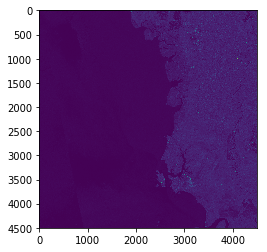

In [5]:
plt.imshow(hh)

In [6]:
hh.shape

(4500, 4500)

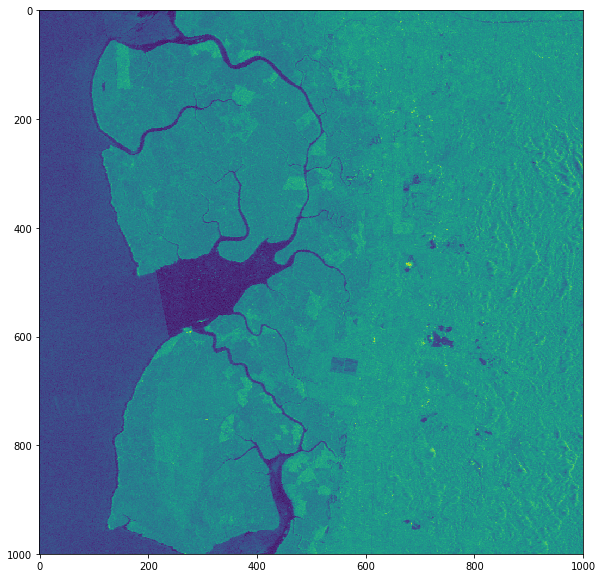

In [7]:
sy = np.s_[1000:2000]
sx = np.s_[2500:3500]
plt.figure(figsize=(10, 10))
plt.imshow(20 * np.log10(hh[sy, sx]))

In [8]:
profile = get_cropped_profile(profile_mosaic, sx, sy)

In [9]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
    return band

def write_one_band(band, dest_path, profile):
    with rasterio.open(dest_path, 'w', **profile) as ds:
        ds.write(band, 1)

In [10]:
bands = list(map(open_one, data))
bands_cropped = list(map(lambda band: band[sy, sx], bands))

In [11]:
out_dir = Path('data/jaxa_mosaics_cropped')
out_dir.mkdir(exist_ok=True)

hv_dir = out_dir/'hv'
hv_dir.mkdir(exist_ok=True, parents=True)

hh_dir = out_dir/'hh'
hh_dir.mkdir(exist_ok=True, parents=True)

for k, band in tqdm(enumerate(bands_cropped), total=len(bands_cropped)):
    dest_name = data[k].name.replace('_F02DAR', '')
    dest_dir = hh_dir if (k % 2) == 0 else hv_dir
    write_one_band(band, dest_dir/f'{dest_name}', profile)

100%|██████████| 16/16 [00:00<00:00, 110.35it/s]


# To Decibels

In [12]:
# Want to remove things less than 0 because that will not transform with log well so we use floor operation
bands_clipped = list(map(lambda band: np.clip(band, .0000001, np.inf), tqdm(bands_cropped)))

100%|██████████| 16/16 [00:00<00:00, 213.60it/s]


In [13]:
# using the transformation from page 6 of
# https://www.eorc.jaxa.jp/ALOS/en/palsar_fnf/DatasetDescription_PALSAR2_Mosaic_FNF_revE.pdf
bands_db = list(map(lambda band: 20 * np.log10(band) -84.66 , tqdm(bands_clipped)))
bands_db = list(map(lambda band: np.clip(band, -40, 0), tqdm(bands_db)))

100%|██████████| 16/16 [00:00<00:00, 232.93it/s]


In [14]:
out_dir = Path('data/jaxa_mosaics_cropped_db')
out_dir.mkdir(exist_ok=True)

p = profile.copy()
p['dtype'] = 'float32'

hv_dir = out_dir/'hv'
hv_dir.mkdir(exist_ok=True, parents=True)

hh_dir = out_dir/'hh'
hh_dir.mkdir(exist_ok=True, parents=True)

for k, band in tqdm(enumerate(bands_db), total=len(bands_db)):
    dest_name = data[k].name.replace('_F02DAR', '')
    dest_dir = hh_dir if (k % 2) == 0 else hv_dir
    write_one_band(band.astype(np.float32), dest_dir/f'{dest_name}', p)

100%|██████████| 16/16 [00:00<00:00, 51.49it/s]


# TV and to Linear Scale

In [15]:
def bwd(img):
    return 10**(img / 20)

def tv_denoise(img_db, weight):
    img_tv = denoise_tv_bregman(img_db, weight)
    return img_tv

def tv_partial(band):
    return tv_denoise(band, .5)

In [16]:
bands_tv = list(map(tv_partial, tqdm(bands_db)))

100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


In [17]:
out_dir = Path('data/jaxa_mosaics_cropped_tv')
out_dir.mkdir(exist_ok=True)

hv_dir = out_dir/'hv'
hv_dir.mkdir(exist_ok=True, parents=True)

hh_dir = out_dir/'hh'
hh_dir.mkdir(exist_ok=True, parents=True)

p = profile.copy()
p['dtype'] = 'float32'

for k, band in tqdm(enumerate(bands_tv), total=len(bands_tv)):
    dest_name = data[k].name.replace('_F02DAR', '')
    dest_dir = hh_dir if (k % 2) == 0 else hv_dir
    write_one_band(band.astype(np.float32), dest_dir/f'{dest_name}', p)

100%|██████████| 16/16 [00:00<00:00, 51.65it/s]


# RGB

In [18]:
out_dir = Path('data/rgb')
out_dir.mkdir(exist_ok=True)

band_tuples = [(bands_tv[2*k], bands_tv[2*k+1]) for k in range(8)]

def make_rgb(data_tuple):
    hh, hv = data_tuple
    m, n = hh.shape
    rgb = np.zeros((m, n, 3))
    
    hh_ = np.clip(hh, -35, -1)
    hv_ = np.clip(hv, -35, -1)

    rgb[..., 0] = scale_img(hh_)
    rgb[..., 1] = scale_img(hv_)
    rgb[..., 2] = np.clip(hh_ / (hv_), 0, 1)

    return rgb
    
rgbs = list(map(make_rgb, band_tuples))

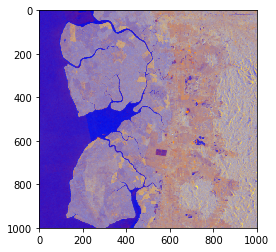

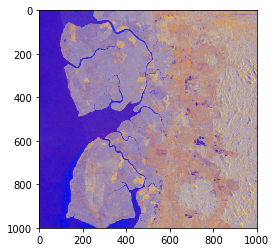

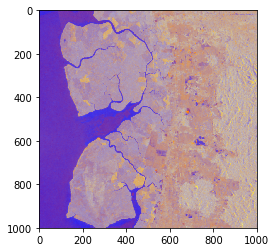

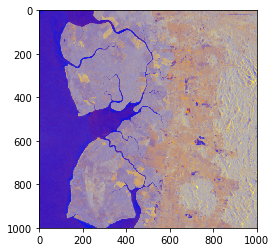

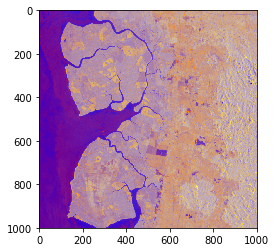

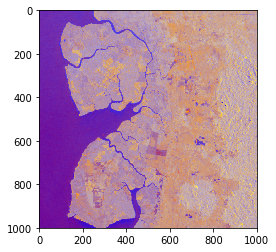

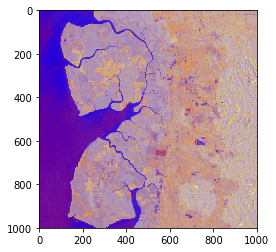

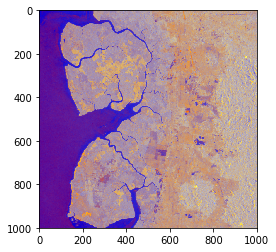

In [19]:
for k in range(8):
    plt.figure()
    plt.imshow(rgbs[k])

In [20]:
p_rgb = p.copy()
p_rgb['count'] = 3

for k, rgb in tqdm(enumerate(rgbs), total=len(rgbs)):
    dest_name = data[2 * k].name[:10]
    dest_name = f'{dest_name}_rgb.tif'
    
    dest_path = out_dir/dest_name
    with rasterio.open(dest_path, 'w', **p_rgb) as ds:
        ds.write(rgb.astype(np.float32).transpose(2, 0, 1))

100%|██████████| 8/8 [00:00<00:00, 20.47it/s]


# Getting Mangrove Extent over Time Series

In [21]:
MANGROVE_SHAPEFILE_PATH = Path('data/GMW_001_GlobalMangroveWatch/01_Data/GMW_2007_v2.shp')

In [22]:
bounds = array_bounds(profile['height'], profile['width'], profile['transform'])
box_geometry = box(*bounds)

This gets all the *full* geometries that have nontrivial intersection with the bounding box, so the area extends past our ROI as we see.

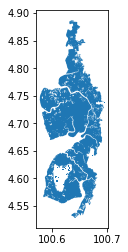

In [23]:
df_mangrove = gpd.read_file(MANGROVE_SHAPEFILE_PATH, bbox=bounds)
df_mangrove.plot()

In [24]:
df_mangrove.head()

,ogc_fid,pxlval,geometry
0,45303.0,1,"POLYGON ((100.6773333333327 4.774000000000226,..."
1,45304.0,1,"POLYGON ((100.6711111111104 4.773777777778004,..."
2,45305.0,1,"POLYGON ((100.6733333333327 4.769333333333564,..."
3,45306.0,1,"POLYGON ((100.678666666666 4.767333333333566, ..."
4,45307.0,1,"POLYGON ((100.6146666666661 4.763777777778014,..."


We do an additional intersection to remove additional geometries. 

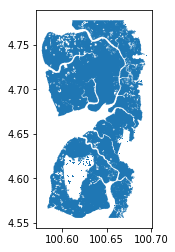

In [25]:
df_mangrove.geometry = df_mangrove.geometry.intersection(box_geometry)
df_mangrove.plot()

In [26]:
df_mangrove.to_file(Path('data')/MANGROVE_SHAPEFILE_PATH.name.replace('.shp', '_cropped_extent'))

# Rasterize Mangrove Area for Mask

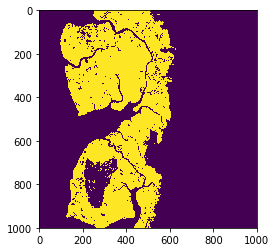

In [27]:
mangrove_mask = rasterize_shapes_to_array(df_mangrove.geometry, df_mangrove.pxlval, profile, all_touched=False)
plt.imshow(mangrove_mask)

In [28]:
p_mangrove = profile.copy()
p_mangrove['count'] = 1
p_mangrove['dtype'] = 'uint8'

with rasterio.open('data/mangrove_extent.tif',  'w', **p_mangrove) as ds:
    ds.write(mangrove_mask.astype(np.uint8), 1)